In [883]:
import requests
from pprint import pprint
import json
import numpy as np
import pandas as pd
import sklearn as sk
from sunlight import congress
from sunlight.pagination import PagingService
import pymysql as mdb
from pandas.io import sql
import cPickle as pickle
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [719]:
paging_service = PagingService(congress)

In [720]:
votes = paging_service.votes(fields='chamber,bill_id,breakdown.total,question,required,voted_at',vote_type='passage',limit=10000)
#file = open('Votes','r')
#votes = pickle.load(file)
#file.close()

In [721]:
votes = pd.DataFrame.from_dict(votes)
votes = votes[votes.question.str.contains('Passage')]

In [722]:
votes['yeas'] = np.zeros(len(votes))
votes['nays'] = np.zeros(len(votes))
votes['no_votes'] = np.zeros(len(votes))
votes['split'] = np.zeros(len(votes))

In [723]:
for i in votes.index: 
    votes['yeas'][i] = votes['breakdown'][i]['total']['Yea']
    votes['nays'][i] = votes['breakdown'][i]['total']['Nay']
    votes['no_votes'][i] = votes['breakdown'][i]['total']['Not Voting']
    votes['split'][i] = votes['yeas'][i]/(votes['yeas'][i]+votes['nays'][i])

/Users/erinboyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/erinboyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/erinboyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/erinboyle

In [724]:
votes = votes.drop('breakdown',1)

In [725]:
votes.head(1)

,bill_id,chamber,question,required,voted_at,yeas,nays,no_votes,split
0,hr2578-114,house,On Passage,1/2,2015-06-03T23:05:00Z,242,183,7,0.569412


In [729]:
len(votes[np.abs(votes.split-.5)<.05]), len(votes)

(63, 524)

In [731]:
votes.bill_id, bills.bill_id

(0        hr2578-114
 1        hr2048-114
 3        hr1335-114
 4        hr1314-114
 5        hr2262-114
 7        hr1806-114
 8         hr880-114
 10       hr2250-114
 11       hr2353-114
 17       hr1735-114
 21       hr1295-114
 22        hr644-114
 23         hr36-114
 24       hr2048-114
 27       hr1732-114
 30       hr1191-114
 32       hr2028-114
 34      hjres43-114
 35       hr2029-114
 41       hr1731-114
 42         s178-114
 43       hr1560-114
 45       hr1195-114
 47        hr622-114
 48       hr1105-114
 52          hr2-114
 53        hr650-114
 54        hr685-114
 60          hr2-114
 67       sjres8-114
            ...     
 2204       s679-112
 2206     hr2055-112
 2207     hr1249-112
 2208     hr2887-112
 2209     hr2832-112
 2210      s1619-112
 2211     hr3080-112
 2212     hr3079-112
 2213     hr3078-112
 2214     hr2112-112
 2215      hr674-112
 2217      s1867-112
 2221     hr3672-112
 2224      s2038-112
 2227      s1813-112
 2228     hr3606-112
 2229      s1

In [786]:
bills = paging_service.bills(fields='bill_id,bill_type,last_action_at,official_title,short_title,popular_title,nicknames,keywords,summary,summary_short,history.active_at,sponsor_id,cosponsor_ids,cosponsors_count,withdrawn_cosponsor_ids,withdrawn_cosponsors_count,committee_ids,related_bill_ids',limit=50000)
bills = pd.DataFrame.from_dict(bills)
#file = open('InitialBillsDF','r')
#initialbills = pickle.load(file)
#file.close()

In [788]:
file = open('InitialBillsDF','w')
pickle.dump(bills, file)
file.close()

In [792]:
file = open('Votes','w')
pickle.dump(votes, file)
file.close()

In [797]:
len(bills), bills.columns

(41366, Index([                   u'bill_id',                  u'bill_type',
                     u'committee_ids',              u'cosponsor_ids',
                  u'cosponsors_count',                    u'history',
                          u'keywords',             u'last_action_at',
                         u'nicknames',             u'official_title',
                     u'popular_title',           u'related_bill_ids',
                       u'short_title',                 u'sponsor_id',
                           u'summary',              u'summary_short',
           u'withdrawn_cosponsor_ids', u'withdrawn_cosponsors_count'],
       dtype='object'))

In [815]:
bills.head(1)

,bill_id,bill_type,cosponsors_count,history,last_action_at,nicknames,official_title,popular_title,short_title,sponsor_id,...,W000796,W000797,W000800,W000802,W000807,W000809,W000813,W000820,Y000031,Y000033
0,hr2644-114,hr,0,{},2015-06-03,NaN,To expedite certain forest management activiti...,None,None,Z000018,...,0,0,0,0,0,0,0,0,0,0


In [837]:
bills['bill_id'] = bills['bill_id'].str.replace(r'h.*[a-z]','h')
bills['bill_id'] = bills['bill_id'].str.replace(r's.*[a-z]','s') 

#bills.bill_id.replace(to_replace=r'h.*[a-z]',value='h',regex=True,inplace=True)
#bills.bill_id.replace(to_replace=r's.*[a-z]',value='s',regex=True,inplace=True)

#for bill_id in bills.bill_id: 
#    bill_id = re.sub('h.*[a-z]','h',bill_id)
#    bill_id = re.sub('s.*[a-z]','s',bill_id)
#bills.bill_id.head(30)

In [799]:
# It would be cool to do this part below by in general checking for the type of a column to be a list and then doing the operation. But don't know how to generalize column name that way.
# Maybe this should be an inner join eventually to eliminate votes without bill info and vice versa
bills = pd.concat([bills, bills['committee_ids'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')
bills = pd.concat([bills, bills['cosponsor_ids'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')
bills = pd.concat([bills, bills['related_bill_ids'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')
bills = pd.concat([bills, bills['keywords'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')
bills = pd.concat([bills, bills['withdrawn_cosponsor_ids'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')
bills = bills.drop(['committee_ids','cosponsor_ids','related_bill_ids','keywords','withdrawn_cosponsor_ids'],1)

In [839]:
file = open('Bills_Reformatted','w')
pickle.dump(bills, file)
file.close()

In [802]:
len(bills.columns)

21144

In [842]:
votes['bill_id'] = votes['bill_id'].str.replace(r'h.*[a-z]','h')
votes['bill_id'] = votes['bill_id'].str.replace(r's.*[a-z]','s') 

In [844]:
#complete = bills.join(votes, on=['bill_id', 'bill_id']) # Wants the match to be complete..?
complete = bills.merge(votes, left_on ="bill_id", right_on ="bill_id")

In [845]:
file = open('Votes_Reformatted','w')
pickle.dump(votes, file)
file.close()

In [822]:
len(votes)

524

In [ ]:
#con = mdb.connect('localhost', 'root', 'reepicheep', 'testdb')
#with con:
#   cur = con.cursor()
#   cur.execute("DROP TABLE IF EXISTS BillVotes")
#   sql.write_frame(complete, con=con, name='BillVotes', if_exists='replace', flavor='mysql')
    #cur.execute("CREATE TABLE BillVotes(Id INT PRIMARY KEY AUTO_INCREMENT,Name VARCHAR(25))")
    #cur.execute("INSERT INTO Writers(Name) VALUES('Jack London')")

In [652]:
print(len(list(paging_service.votes(fields='chamber',vote_type='passage',limit=50000))))

2251


In [711]:
#con = mdb.connect('localhost', 'root', 'reepicheep', 'testdb')

In [ ]:
#with con:
#    cur = con.cursor()
#    cur.execute('create table if not exists bills')
#    sql.write_frame(bills, con=con, name='Bills', if_exists = 'replace', flavor='mysql')

In [846]:
file = open('InitialBillsDF','r')
initialbills = pickle.load(file)
file.close()
initialbills['bill_id'] = initialbills['bill_id'].str.replace(r'h.*[a-z]','h')
initialbills['bill_id'] = initialbills['bill_id'].str.replace(r's.*[a-z]','s') 

In [847]:
file = open('InitialBills_IDformatted','w')
pickle.dump(initialbills, file)
file.close()

In [848]:
fewerparams = initialbills.merge(votes, left_on ="bill_id", right_on ="bill_id")
file = open('Merged_fewer_params','w')
pickle.dump(fewerparams, file)
file.close()

In [855]:
len(fewerparams)

810

In [868]:
maxx = 0
minn = 1000
for bill in votes['bill_id']:
    if int(bill[-3:]) > maxx:
        maxx = int(bill[-3:])
    if int(bill[-3:]) < minn:
        minn = int(bill[-3:])
print maxx, minn
maxx = 0
minn = 1000
for bill in bills['bill_id']:
    if int(bill[-3:]) > maxx:
        maxx = int(bill[-3:])
    if int(bill[-3:]) < minn:
        minn = int(bill[-3:])
print maxx, minn

114 111
114 111


In [ ]:
#fig = plt.figure()
#colors = ['b','b','b','b','b','b','b','b','b','r','r','b','b','b','b','b','b','b','b','b']
histdat = fewerparams.split

In [1000]:
type(histdat)

pandas.core.series.Series

In [1001]:
fs = 20
dpi = 250

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


(array([  23.,  321.]),
 array([ 0.43062201,  0.51507681,  0.59953162]),
 <a list of 2 Patch objects>)

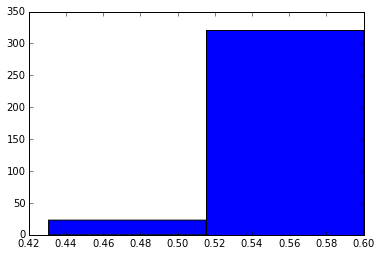

In [1086]:
subset = histdat[histdat<.6] #[histdat < .55]
subset = subset[subset>.4]
print type(histdat), type(subset)
plt.figure()
plt.hist(subset, bins=2) #, color='red')

KeyError: 0

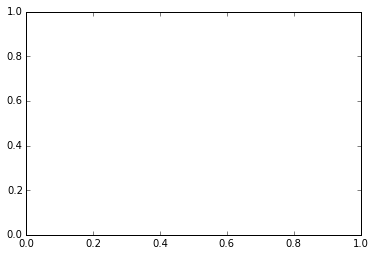

In [1063]:
plt.hist(histdat,bins=20)
#fig = fewerparams.hist(column='split',bins=20) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
#fig[9].set_color('r')
closecalls = (len(histdat[np.abs(histdat-.5)<.05])/np.float(len(histdat)))
plt.title('All bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.hold(True)

#bins = np.linspace(0, 1, 21)
#digitized = np.digitize(histdat, bins)
#closeones = [len(digitized[digitized==10]),len(digitized[digitized==11])]

#plt.savefig("Histograms/AllBills.png", dpi=dpi)

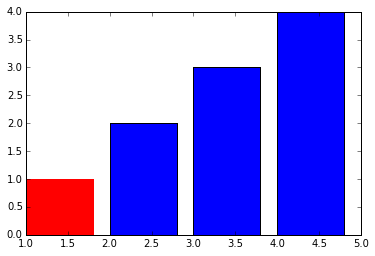

In [1042]:
barlist=plt.bar([1,2,3,4], [1,2,3,4])
barlist[0].set_color('r')
plt.show()

In [1041]:
bins = np.linspace(0, 1, 21)
digitized = np.digitize(histdat, bins)
closeones = [len(digitized[digitized==10]),len(digitized[digitized==11])]

In [ ]:
barlist=plt.bar(bins,digitized)
barlist[0].set_color('r')
plt.show()

In [913]:
fewerparams.columns

Index([                   u'bill_id',                  u'bill_type',
                    u'committee_ids',              u'cosponsor_ids',
                 u'cosponsors_count',                    u'history',
                         u'keywords',             u'last_action_at',
                        u'nicknames',             u'official_title',
                    u'popular_title',           u'related_bill_ids',
                      u'short_title',                 u'sponsor_id',
                          u'summary',              u'summary_short',
          u'withdrawn_cosponsor_ids', u'withdrawn_cosponsors_count',
                          u'chamber',                   u'question',
                         u'required',                   u'voted_at',
                             u'yeas',                       u'nays',
                         u'no_votes',                      u'split'],
      dtype='object')

In [915]:
fewerparams = pd.concat([fewerparams, fewerparams['keywords'].str.join(sep=', ').str.get_dummies(sep=', ')], axis=1, join='outer')

In [941]:
volunteer = fewerparams[fewerparams['volunteer service']==1]
weapons = fewerparams[fewerparams['weapons development']==1]
trees = fewerparams[fewerparams['trees']==1]
abortion = fewerparams[fewerparams['Abortion']==1]
climate = fewerparams[fewerparams['Climate change and greenhouse gases']==1]
cdc = fewerparams[fewerparams['Centers for Disease Control and Prevention (CDC)']==1]
print len(volunteer),len(weapons),len(trees),len(abortion),len(climate),len(cdc)

47 50 38 27 53 11


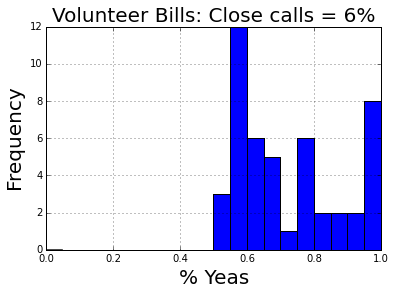

In [1003]:
fig = volunteer.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(volunteer[np.abs(volunteer.split-.5)<.05])/np.float(len(volunteer)))
plt.title('Volunteer Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/Volunteer.png", dpi=dpi)

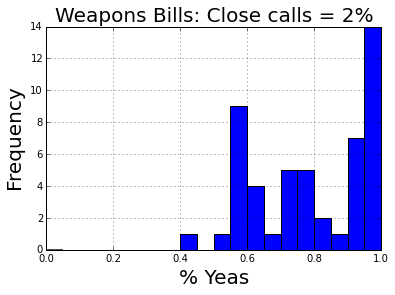

In [1004]:
fig = weapons.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(weapons[np.abs(weapons.split-.5)<.05])/np.float(len(weapons)))
plt.title('Weapons Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/Weapons.png", dpi=dpi)

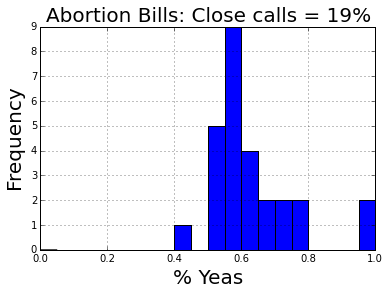

In [1005]:
fig = abortion.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(abortion[np.abs(abortion.split-.5)<.05])/np.float(len(abortion)))
plt.title('Abortion Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/Abortion.png", dpi=dpi)

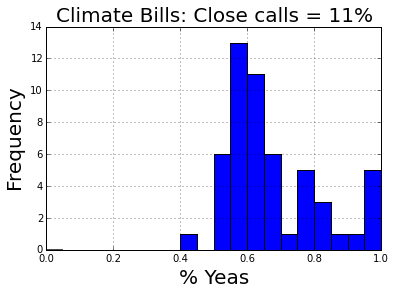

In [1006]:
fig = climate.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(climate[np.abs(climate.split-.5)<.05])/np.float(len(climate)))
plt.title('Climate Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/Climate.png", dpi=dpi)

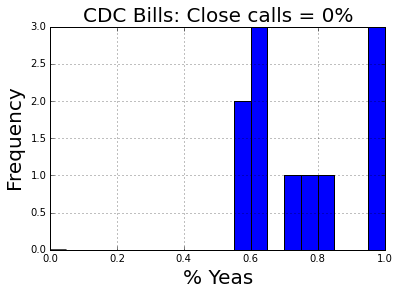

In [1007]:
fig = cdc.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(cdc[np.abs(cdc.split-.5)<.05])/np.float(len(cdc)))
plt.title('CDC Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/CDC.png", dpi=dpi)

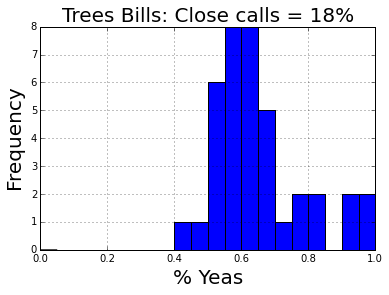

In [1008]:
fig = trees.hist(column='split',bins=np.arange(0,1.05,.05)) #,color=colors)
plt.xlabel('% Yeas', fontsize = fs)
plt.ylabel('Frequency', fontsize = fs)
closecalls = (len(trees[np.abs(trees.split-.5)<.05])/np.float(len(trees)))
plt.title('Trees Bills: Close calls = '+str(int(np.round(closecalls,2)*100))+'%', fontsize = fs)
plt.savefig("Histograms/Trees.png", dpi=dpi)

In [1010]:
bills.head(1)

,bill_id,bill_type,cosponsors_count,history,last_action_at,nicknames,official_title,popular_title,short_title,sponsor_id,...,W000796,W000797,W000800,W000802,W000807,W000809,W000813,W000820,Y000031,Y000033
0,h2644-114,hr,0,{},2015-06-03,NaN,To expedite certain forest management activiti...,None,None,Z000018,...,0,0,0,0,0,0,0,0,0,0


In [1023]:
print bills.columns
titl = bills['official_title'][41361:41362]

Index([         u'bill_id',        u'bill_type', u'cosponsors_count',
                u'history',   u'last_action_at',        u'nicknames',
         u'official_title',    u'popular_title',      u'short_title',
             u'sponsor_id', 
       ...
                u'W000796',          u'W000797',          u'W000800',
                u'W000802',          u'W000807',          u'W000809',
                u'W000813',          u'W000820',          u'Y000031',
                u'Y000033'],
      dtype='object', length=21144)


In [1024]:
print titl

41361    A bill to reform schools and give America's ch...
Name: official_title, dtype: object


In [1022]:
len(titl)

1

In [1025]:
billsbillsbills = paging_service.bills(fields='bill_id,bill_type,last_action_at,official_title,short_title,popular_title,nicknames,keywords,summary,summary_short,history.active_at,sponsor_id,cosponsor_ids,cosponsors_count,withdrawn_cosponsor_ids,withdrawn_cosponsors_count,committee_ids,related_bill_ids',limit=50000)